# Burger example from Report

In [84]:
import torch
import sys
import matplotlib.pyplot as plt

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from UPINN import UPINN
from Architectures import FNN
from Utils import RAD_sampler
# from kan import KAN, KANLinear

In [85]:
# Initial condition
N_ic = 100
u0 = lambda x: -torch.sin(torch.pi * x)
x0 = torch.linspace(-1, 1, N_ic)
t0 = torch.zeros_like(x0)
X0 = torch.stack((t0, x0), dim=-1)
U0 = u0(x0).reshape(-1, 1)

# Boundary condition
N_bc = 100
uL = lambda t: torch.zeros_like(t)
uR = lambda t: torch.zeros_like(t)
tL = torch.linspace(0, 1, N_bc)
tR = torch.linspace(0, 1, N_bc)
xL = -torch.ones_like(tL)
xR = torch.ones_like(tR)
XL = torch.stack((tL, xL), dim=-1)
XR = torch.stack((tR, xR), dim=-1)

# All boundary conditions
Xbc = torch.cat((X0, XL, XR), dim=0)
Ubc = torch.cat((U0, uL(tL).reshape(-1, 1), uR(tR).reshape(-1, 1)), dim=0)

In [86]:
# Collocation points
N_coll = 1000
sobol = torch.quasirandom.SobolEngine(dimension=2)
Xc = sobol.draw(n=N_coll, dtype=torch.float32)
Xc[:, 1] = Xc[:, 1]*2 - 1

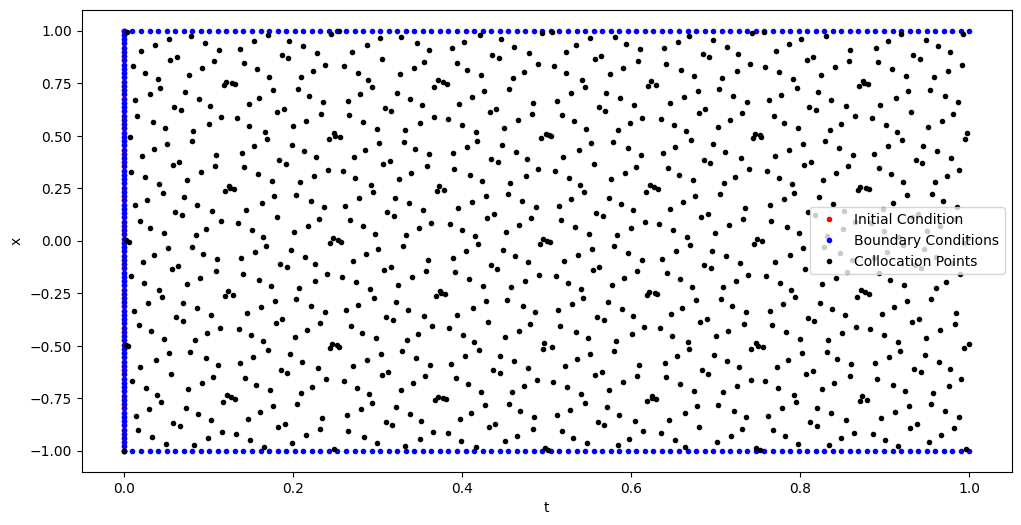

In [87]:
# Plot the initial condition, boundary conditions, and collocation points
plt.figure(figsize=(12, 6))
plt.plot(X0[:, 0], X0[:, 1], 'r.', label='Initial Condition')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(Xc[:, 0], Xc[:, 1], 'k.', label='Collocation Points')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

In [88]:
class Burger(torch.nn.Module):
    def __init__(self, nu):
        super(Burger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        dudxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        
        u_xx = torch.autograd.grad(dudxt, X, torch.ones_like(dudxt), create_graph=True)[0][:,1:2]

        return u_t + u*u_x - self.nu*u_xx

In [89]:
class UPINN(UPINN):

    def refine_collocation_points(self):
        N = 100000
        D = 1000
        k = 2
        c = 0

        Xc = sobol.draw(n=N, dtype=torch.float32)
        Xc[:, 1] = Xc[:, 1]*2 - 1
        Xc.requires_grad_(True)

        # Compute the residual
        u = self.u(Xc)
        residual = abs(self.N(Xc, u))
        
        self.collocation_points = RAD_sampler(Xc, residual, D, k, c)
    
    def plot(self):
        # Plot the initial condition, boundary conditions, and collocation points
        plt.figure(figsize=(12, 6))
        plt.plot(self.boundary_points[0][:, 0], self.boundary_points[0][:, 1], 'b.', label='Boundary Conditions')
        plt.plot(self.collocation_points[:, 0].detach(), self.collocation_points[:, 1].detach(), 'k.', label='Collocation Points')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend()
        plt.show()

In [90]:
# Define model architectures
hidden = [20] * 8
u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

nu = 0.01/torch.pi
N = Burger(nu)

# Instantiate the PINN
upinn = UPINN(u, N, boundary_points=(Xbc, Ubc), collocation_points=Xc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


In [91]:
optimizer = torch.optim.Adam(upinn.parameters(), lr=1e-3)
upinn.optimizer = optimizer
upinn.train_loop(1000)

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:14<00:00, 67.40 epoch/s, L=1.30e-02, L_bc=2.98e-02, L_data=0.00e+00, L_pde=9.29e-03]


In [95]:
# Write upinn.collocation points to txt file
X = upinn.collocation_points
X = X.detach().numpy()
X = X.reshape(-1, 2)
f = open("collocation_points.txt", "w")
for i in range(len(X)):
    f.write(str(X[i][0]) + "," + str(X[i][1]) + "\n")
f.close()

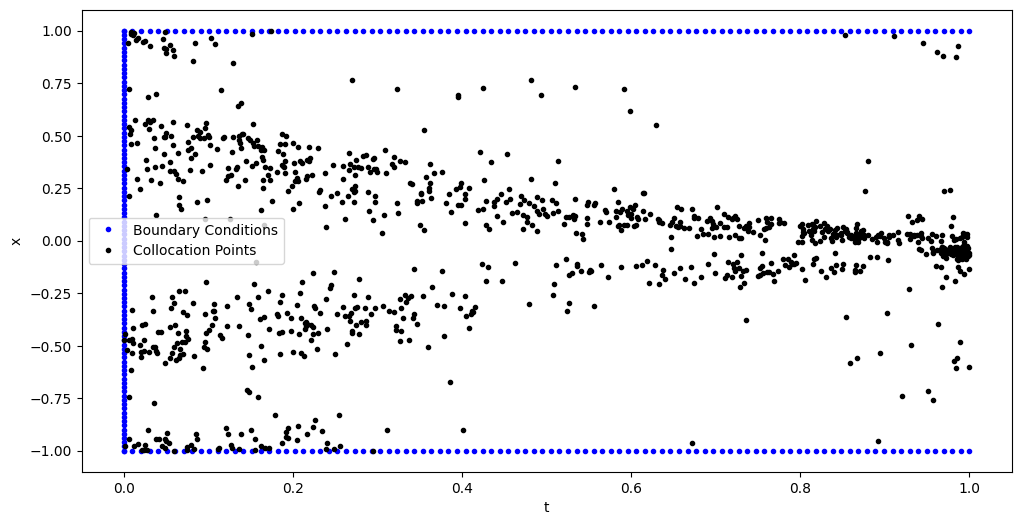

In [93]:
upinn.refine_collocation_points()
upinn.plot()

In [94]:
N = 100
D = 10000
k = 2
c = 0

Xc = sobol.draw(n=N_coll, dtype=torch.float32)
Xc[:, 1] = Xc[:, 1]*2 - 1
Xc.requires_grad_(True)

# Compute the residual
u = upinn.u(Xc)
residual = abs(upinn.N(Xc, u))
        
upinn.collocation_points = RAD_sampler(Xc, residual, D, k, c)


plt.scatter(Xc[:, 0].detach(), Xc[:, 1].detach(), c=residual.detach(), cmap='viridis')


RuntimeError: cannot sample n_sample > prob_dist.size(-1) samples without replacement